In [30]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import glob
import numpy as np
import random
import itertools
from collections import Counter

# import nltk
# from nltk.corpus import stopwords
# from nltk.tokenize import word_tokenize
# nltk.download('punkt')

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
bbc_sport_dir = 'bbcsport/'
sport_categories = {
    0: 'athletics',
    1: 'cricket',
    2: 'football',
    3: 'rugby',
    4: 'tennis'
}

sport_text_and_label = []

for idx, label in sport_categories.items():    
    for file_name in glob.glob(bbc_sport_dir + label + '/*.txt'):
        with open(file_name, 'r', encoding='utf8', errors='ignore') as news_file:
            text = news_file.read()
            
#             text_tokenized = word_tokenize(text)
#             text_wo_stopword = [word for word in text_tokenized if not word in STOPWORDS]
            
#             text = ' '.join(text_wo_stopword)
            
        sport_text_and_label.append([text, idx])
        
random.shuffle(sport_text_and_label)

In [3]:
# print counts by category from Counter
def show_counts(labels):
    
    # Count total number of each label
    counter = Counter(l for l in labels)
    counter = sorted(counter.items())
    
    print('Document Counts by Category:')
    
    for label, count in counter:
        cat = sport_categories.get(label)
        print("'{}': {}".format(cat, count))

In [4]:
# Shuffle documents for random sampling
random.shuffle(sport_text_and_label)

# Seperate text and label into two lists
sport_text = [text[0] for text in sport_text_and_label]
sport_label = [label[1] for label in sport_text_and_label]

# Take the first 200 documents as imbalence sample
sample_text = sport_text[:200]
sample_label = sport_label[:200]

# Remaining text and label for model trainning
remain_text = sport_text[200:]
remain_label = sport_label[200:]

In [5]:
print("Total Numbers of Sport Documents: {}".format(len(sport_text_and_label)))
show_counts(sport_label)

print("\nNumbers of Documents in Imbalence Sample: {}".format(len(sample_text)))
show_counts(sample_label)

print("\nNumbers of Documents in Remaining Data: {}".format(len(remain_text)))
show_counts(remain_label)

Total Numbers of Sport Documents: 737
Document Counts by Category:
'athletics': 101
'cricket': 124
'football': 265
'rugby': 147
'tennis': 100

Numbers of Documents in Imbalence Sample: 200
Document Counts by Category:
'athletics': 21
'cricket': 38
'football': 70
'rugby': 44
'tennis': 27

Numbers of Documents in Remaining Data: 537
Document Counts by Category:
'athletics': 80
'cricket': 86
'football': 195
'rugby': 103
'tennis': 73


In [6]:
# Create tokenizer for vectorizing documents, using the top 3000 most common words only
tokenizer = Tokenizer(num_words=3000)

# Updates internal vocabulary based on the BBC Sport Documents
tokenizer.fit_on_texts(sport_text)

# Transform each document into sequence
sport_seq = tokenizer.texts_to_sequences(remain_text)
sample_seq = tokenizer.texts_to_sequences(sample_text)

# Use padding to ensure each sequence has the same length
sport_pad = pad_sequences(sport_seq, maxlen=300, padding='post', truncating='post')
sample_pad = pad_sequences(sample_seq, maxlen=300, padding='post', truncating='post')

sport_labels = np.array(remain_label)
sport_labels = sport_labels.reshape(537, 1)

sample_labels = np.array(sample_label)
sample_labels = sample_labels.reshape(200, 1)

In [26]:
glove = open('glove/glove.6B.100d.txt', encoding='utf8')

embeddings_dict = dict()

for line in glove:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dict[word] = vector_dimensions

glove.close()

# Get the first 3000 most common word index from the tokenizer
word_to_idx = dict(itertools.islice(tokenizer.word_index.items(), 3000))


embeddings_dict = dict(itertools.islice(embeddings_dict.items(), 3000))

embedding_matrix = np.zeros((3000, 100))
for word, index in word_to_idx.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index - 1] = embedding_vector

In [28]:
def get_samples(sample_size=200):
    # Shuffle documents for random sampling
    random.shuffle(sport_text_and_label)

    # Seperate text and label into two lists
    sport_text = [text[0] for text in sport_text_and_label]
    sport_label = [label[1] for label in sport_text_and_label]

    # Take the first 200 documents as imbalence sample
    sample_text = sport_text[:sample_size]
    sample_label = sport_label[:sample_size]

#     print("\nNumbers of Documents in Imbalence Sample: {}".format(len(sample_text)))
#     show_counts(sample_label)
    
#     Split the sample data into train, test and validation set
    sample_train_text, sample_test_text, sample_train_label, sample_test_label = train_test_split(
            sample_text, sample_label, test_size=0.2
    )
    train_size = len(sample_train_text)
    test_size = len(sample_test_text)

    # Transform each document into sequence
    sample_train_seq = tokenizer.texts_to_sequences(sample_train_text)
    sample_test_seq = tokenizer.texts_to_sequences(sample_test_text)

    # Use padding to ensure each sequence has the same length
    sample_train_pad = pad_sequences(sample_train_seq, maxlen=300, padding='post', truncating='post')
    sample_test_pad = pad_sequences(sample_test_seq, maxlen=300, padding='post', truncating='post')
    
    sample_train_label = np.array(sample_train_label)
    sample_train_label = sample_train_label.reshape(train_size, 1)
    
    sample_test_label = np.array(sample_test_label)
    sample_test_label = sample_test_label.reshape(test_size, 1)
    
    return sample_train_pad, sample_train_label, sample_test_pad, sample_test_label

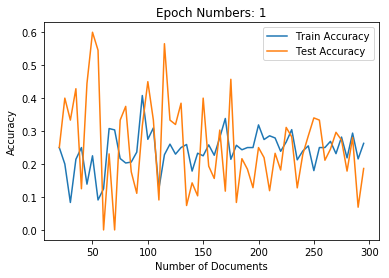

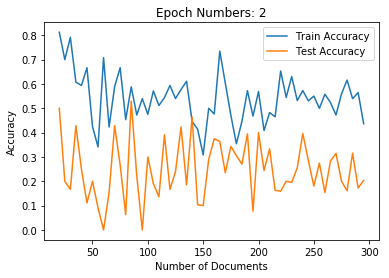

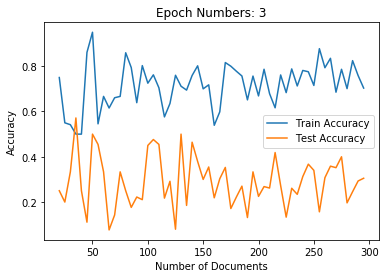

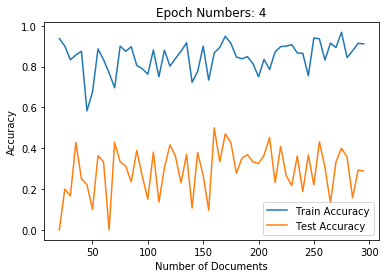

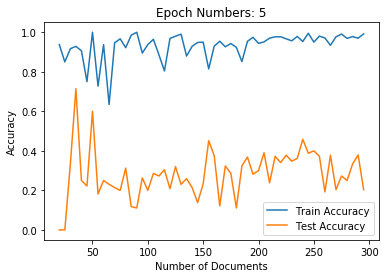

In [31]:
'''
After retriving the pre-trained embedding, we take random sample from the sport text,
for each sample, we split it into train, test set (0.8,0.2) and fit into a model
with pre-trained embedding (the embedding layer is freezed, not trainable).

With different training epochs (start from 1 epoch) to train the model,
we take different random sample size and plot out each training and testing accuracy

    eg. at loop with epoch = 3, size = 200, 
        we take sample size of 200 documents and split them into train, test set,
        build the model with pre-trained embedding with epoch = 3 to train on the sample data,
        then plot out the final training accuracy and testing accuracy
'''

# Training epoch
for epoch in range(1, 6):
    record = []
    for size in range(20, 300, 5):
        
        # Get sample for trainning and testing
        sample_train_pad, sample_train_label, sample_test_pad, sample_test_label = get_samples(size)

        # Create embedding layer based on the pre=trained embedding
        embedding_layer = tf.keras.layers.Embedding(3000, 100, 
                                      embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), 
                                      input_length=300)
        embedding_layer.trainable = False
        
        # Create model for testing the sample documents based on the pre-trained embedding
        trained_model = tf.keras.Sequential([
            embedding_layer,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(5, activation='softmax')
        ])

        trained_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

        history = trained_model.fit(sample_train_pad, sample_train_label, epochs=epoch, verbose=0)
        loss, test_accuracy = trained_model.evaluate(sample_test_pad, sample_test_label, verbose=0)
        # predictions = trained_model.predict_classes(sample_test_pad)
        # tf.math.confusion_matrix(sample_test_label, predictions, num_classes=5)

        # Record trainning accuracy (last epoch) and testing accuracy
        record.append((history.history['accuracy'][-1], test_accuracy))

    fig = plt.figure()
    plt.plot(range(20, 300, 5), [train_acc for train_acc, test_acc in record], label='Train Accuracy')
    plt.plot(range(20, 300, 5), [test_acc for train_acc, test_acc in record], label='Test Accuracy')
    plt.legend()
    plt.title('Epoch Numbers: {}'.format(epoch))
    plt.xlabel('Number of Documents')
    plt.ylabel('Accuracy')
    plt.show()